In [7]:
# Set our python libraries to dynamically reload so that we can edit
# the external text file while calling the function in the notebook
# without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [8]:
# Import all of the functions from our custom functions library
from function_library import *

In [23]:
# Import external libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import warnings

warnings.simplefilter('ignore')

# Get a linear regression model object for later use
linreg = LinearRegression()

# Goal

In this project, we aim to be able to predict the housing prices in King County using linear regression. We will approach this problem by attempting to answer these three questions:
1. How do log transformations of both the regressors and the target affect our model?
1. How does normalization of the data using standardization affect both our R squared and root mean squared error?
1. How does one hot encoding of zipcode affect our overall ability to predict the price of a home in the King County area?

Let's start off by plotting where the houses in the database are located and using color to indicate the sale price.

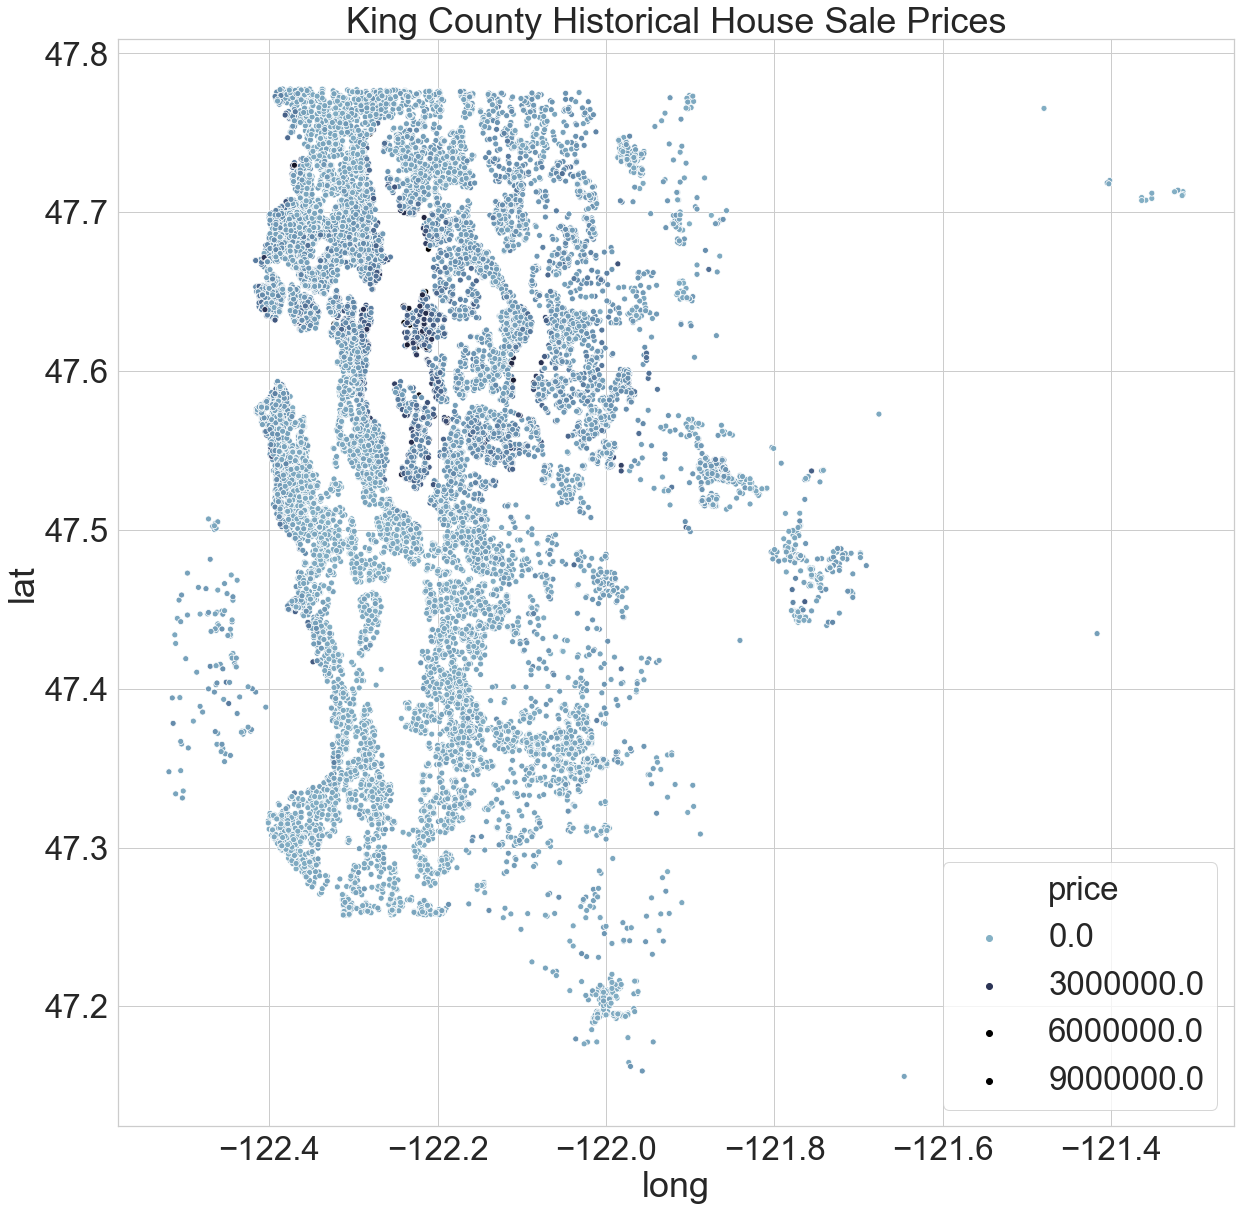

In [46]:
sns.set(font_scale = 3, style='whitegrid')

plt.figure(figsize=(20,20))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True, light =.65, dark = -.5)

plt.title('King County Historical House Sale Prices')

ax = sns.scatterplot(x=df.long, y=df.lat,
                     hue=df.price, 
                     palette=cmap, sizes=(200, 200))

It looks like there is significant spatial heterogeneity in the prices of homes, which is expected. We will eventually use this information (in the form of zipcodes) to help us predict the prices of home sales.

# Data overview

The following data descriptions were included with the data.

In [4]:
! cat column_names.md

# Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the neares

# Data cleaning

- Columns that are not useful for predicting prices were dropped
-- id
- Rows of data that information that may be critical for prediction were dropped
 - waterfront
 - view
- Similar types of data were converted to compatible types
 - date
 - yr_built
 - yr_renovated
- Missing data was filled in using reasonable replacements
 - yr_built → yr_renovated
 - sqft_basement ? → 0.0


# Model evaluation approach
- Perform 10 independent test-train splits
- Train on ⅔ of the data, test on ⅓ of the data
- R-squared and root-mean-squared error values presented hereafter are averages over the 10 test-train splits
- The R-squareds and RMSEs tend to have a relatively narrow distribution and are therefore well-represented by the mean

# Initial model
- We used Scikit-Learn to build an ordinary least squares linear regression model
- The target variable for prediction was “price”
- Initially, we test a model without log transformations, normalization, or one-hot encoding of zipcodes


Mean train error:  201997
 Mean test error:  203407

Mean train rsq:  0.70
 Mean test rsq:  0.70

Mean train adj rsq:  0.70
 Mean test adj rsq:  0.70

R-squared:  0.70, RMSE:  203407


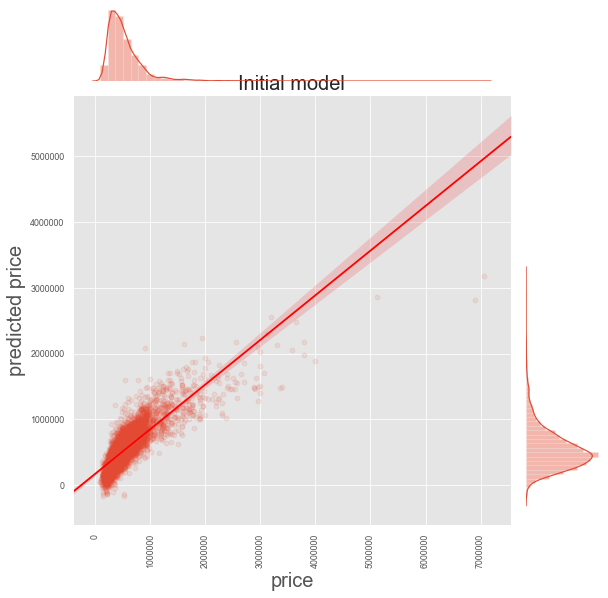

In [43]:
# Boolean variables that control
log_transform_data = False
normalize_data = False
add_onehot_zipcodes = False

num_splits = 10 # We will perform 10 independent test-train splits whenever testing a model
test_size = 0.33 # We will use 2/3 of the data to train and 1/3 of the data to test
log_transform_variables = ['price', 'bedrooms', 'bathrooms', 'sqft_living', # We have chosen these variables
                           'sqft_lot', 'floors', 'condition', 'grade',      # for log transformation
                           'sqft_above', 'sqft_living15', 'sqft_lot15']
perform_checks = False # Can be used to test various assumptions for applying linear regression
apply_feature_selection = False # Can be used to systematically reduce the number of features used to make predictions
n_features_to_select = 10 # The number of features to reach during feature selection
columns_to_standardize = ['bedrooms', 'bathrooms', # These chosen variables will be standardized using Z-score normalization
                                'sqft_living', 'sqft_lot', 'floors', 
                                'condition', 'grade', 'sqft_above',
                                'sqft_living15', 'sqft_lot15']


### Loading data
df = load_kc_data(filename='kc_house_data.csv', verbose=False)

### Checking and cleaning data
df = replace_with_year(df, 'date') # Take only the year information from the date column
                                   # We assume that the month and day are not useful for predicting price
df = drop_columns(df, ["id"])      # Drop the id column, which we assume is not useful for prediction
df = drop_na_rows(df, ["waterfront", "view"]) # Drop the rows that have NA values for waterfront and view
                                              # These columns may be important for predicting price and 
                                              # it is not obvious how to fill these missing values. Furthermore,
                                              # there are relatively few rows with missing values in these columns.
df = convert_columns_with_types(df, "yr_renovated", int, fill_na=True) # Convert yr_renovated to int for compatibility
                                                                       # with the date and yr_built columns
# There are many missing values in yr_renovated, so we fill those missing values with yr_built
df = replace_values_with_another_column(df, [0], "yr_renovated", "yr_built", replace_na=True)
# We will the ? values in sqft_basement with zeros
df = replace_values_with_value(df, '?', 'sqft_basement', '0.0')
# Now that the ? have been changed to zeros, change column type to numeric
df = convert_columns_with_function(df, "sqft_basement", pd.to_numeric)

# Get all of the zipcodes in case one or more zipcodes is missing from a given train-test split of the data
all_zipcodes=df['zipcode'].unique().tolist() 

### Loop over train-test splits and compute and store model quality metrics
train_err = []
test_err = []
train_rsqs = []
test_rsqs = []
train_adj_rsqs = []
test_adj_rsqs = []
for i in range(num_splits):
    ### Split predictors and target for full dataset
    X = df.drop(labels=["price"], axis=1)
    y = df["price"]

    ### Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    ### Build training and test dataframes
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    ### Add onehot zipcodes
    if add_onehot_zipcodes:
        train_df = add_dummy_zipcodes(train_df, all_zipcodes)
        test_df = add_dummy_zipcodes(test_df, all_zipcodes)

    ### Transforming data
    if log_transform_data:
        train_df, train_log_transformed_columns = log_transform_columns(train_df, log_transform_variables,
                                                                  replace_only_when_improved=False, verbose=False, mute=True)
        test_df, test_log_transformed_columns = log_transform_columns(test_df, train_log_transformed_columns,
                                                                  replace_only_when_improved=False, verbose=False, mute=True)

    ### Normalizing data
    if normalize_data:
        normalization_df = train_df.copy()
        train_df = scale_and_normalize_columns(train_df, columns_to_standardize, 
                                               [standardization]*len(columns_to_standardize), fit_df=normalization_df)
        test_df = scale_and_normalize_columns(test_df, columns_to_standardize, 
                                               [standardization]*len(columns_to_standardize), fit_df=normalization_df)

    ### Checking if the data satisfy the assumptions for linear regression
    if perform_checks:
        check_for_linear_correlations(df, target='price')
        check_for_normality(df)
        #check_for_heteroscedasticity ## not yet implemented

    ### Apply feature selection
    if apply_feature_selection:
        rfe_features = recursive_feature_elimination_get_features(df, "price", n_features_to_select=n_features_to_select)
        print(rfe_features)
        df = df.loc[:,rfe_features + ["price"]]

    ### Build the model
    train_linreg = build_linear_model_sklearn(train_df, "price")

    ### Compute errors and correlation coefficients
    if log_transform_data:
        y_hat_train = np.exp(get_predictions_from_linear_model_sklearn(train_df, train_linreg, "price"))
        y_hat_test = np.exp(get_predictions_from_linear_model_sklearn(test_df, train_linreg, "price"))
        train_err.append(np.sqrt(mean_squared_error(np.exp(train_df["price"]), y_hat_train)))
        test_err.append(np.sqrt(mean_squared_error(np.exp(test_df["price"]), y_hat_test)))
    else:
        y_hat_train = get_predictions_from_linear_model_sklearn(train_df, train_linreg, "price")
        y_hat_test = get_predictions_from_linear_model_sklearn(test_df, train_linreg, "price")
        train_err.append(np.sqrt(mean_squared_error(train_df["price"], y_hat_train)))
        test_err.append(np.sqrt(mean_squared_error(test_df["price"], y_hat_test)))

    train_rsq = get_rsq_sklearn(train_df, train_linreg, "price")
    train_rsqs.append(train_rsq)
    train_adj_rsq = get_adjusted_rsq_sklearn(train_df, train_linreg, "price")
    train_adj_rsqs.append(train_adj_rsq)

    test_rsq = get_rsq_sklearn(test_df, train_linreg, "price")
    test_rsqs.append(test_rsq)
    test_adj_rsq = get_adjusted_rsq_sklearn(test_df, train_linreg, "price")
    test_adj_rsqs.append(test_adj_rsq)

# Compute and print mean model quality metrics
mean_train_err = np.mean(train_err)
mean_test_err = np.mean(test_err)
mean_train_rsq = np.mean(train_rsqs)
mean_test_rsq = np.mean(test_rsqs)
mean_train_adj_rsq = np.mean(train_adj_rsqs)
mean_test_adj_rsq = np.mean(test_adj_rsqs)
print(f"Mean train error: {mean_train_err: .0f}\n Mean test error: {mean_test_err: .0f}\n")
print(f"Mean train rsq: {mean_train_rsq: .2f}\n Mean test rsq: {mean_test_rsq: .2f}\n")
print(f"Mean train adj rsq: {mean_train_adj_rsq: .2f}\n Mean test adj rsq: {mean_test_adj_rsq: .2f}\n")

print(f"R-squared: {mean_test_rsq: .2f}, RMSE: {mean_test_err: .0f}")

# Plot the results on the train and test sets of data
plot_predictions_vs_reality(test_df, "price", y_hat_test, 
                            log_transform_target=log_transform_data, title="Initial model")

# Log transformation of data
We selected a few variables to log transform to make their distributions more normal.

Mean train error:  189846
 Mean test error:  191228

Mean train rsq:  0.77
 Mean test rsq:  0.77

Mean train adj rsq:  0.77
 Mean test adj rsq:  0.77

R-squared:  0.77, RMSE:  191228


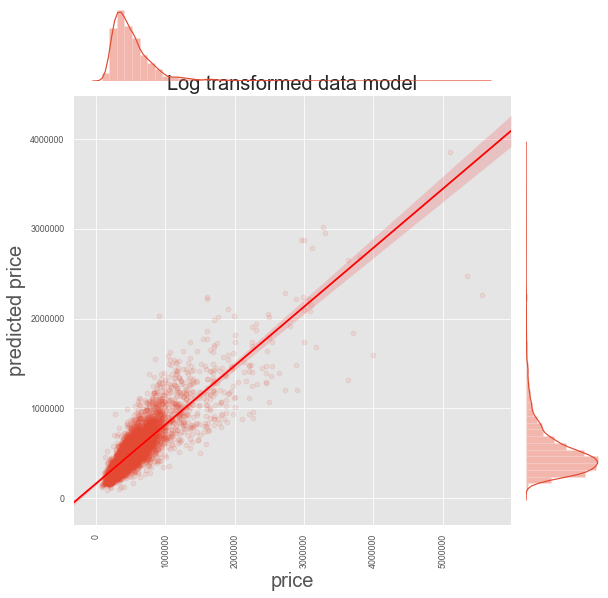

In [42]:
# Boolean variables that control
log_transform_data = True
normalize_data = False
add_onehot_zipcodes = False

num_splits = 10 # We will perform 10 independent test-train splits whenever testing a model
test_size = 0.33 # We will use 2/3 of the data to train and 1/3 of the data to test
log_transform_variables = ['price', 'bedrooms', 'bathrooms', 'sqft_living', # We have chosen these variables
                           'sqft_lot', 'floors', 'condition', 'grade',      # for log transformation
                           'sqft_above', 'sqft_living15', 'sqft_lot15']
perform_checks = False # Can be used to test various assumptions for applying linear regression
apply_feature_selection = False # Can be used to systematically reduce the number of features used to make predictions
n_features_to_select = 10 # The number of features to reach during feature selection
columns_to_standardize = ['bedrooms', 'bathrooms', # These chosen variables will be standardized using Z-score normalization
                                'sqft_living', 'sqft_lot', 'floors', 
                                'condition', 'grade', 'sqft_above',
                                'sqft_living15', 'sqft_lot15']


### Loading data
df = load_kc_data(filename='kc_house_data.csv', verbose=False)

### Checking and cleaning data
df = replace_with_year(df, 'date') # Take only the year information from the date column
                                   # We assume that the month and day are not useful for predicting price
df = drop_columns(df, ["id"])      # Drop the id column, which we assume is not useful for prediction
df = drop_na_rows(df, ["waterfront", "view"]) # Drop the rows that have NA values for waterfront and view
                                              # These columns may be important for predicting price and 
                                              # it is not obvious how to fill these missing values. Furthermore,
                                              # there are relatively few rows with missing values in these columns.
df = convert_columns_with_types(df, "yr_renovated", int, fill_na=True) # Convert yr_renovated to int for compatibility
                                                                       # with the date and yr_built columns
# There are many missing values in yr_renovated, so we fill those missing values with yr_built
df = replace_values_with_another_column(df, [0], "yr_renovated", "yr_built", replace_na=True)
# We will the ? values in sqft_basement with zeros
df = replace_values_with_value(df, '?', 'sqft_basement', '0.0')
# Now that the ? have been changed to zeros, change column type to numeric
df = convert_columns_with_function(df, "sqft_basement", pd.to_numeric)

# Get all of the zipcodes in case one or more zipcodes is missing from a given train-test split of the data
all_zipcodes=df['zipcode'].unique().tolist() 

### Loop over train-test splits and compute and store model quality metrics
train_err = []
test_err = []
train_rsqs = []
test_rsqs = []
train_adj_rsqs = []
test_adj_rsqs = []
for i in range(num_splits):
    ### Split predictors and target for full dataset
    X = df.drop(labels=["price"], axis=1)
    y = df["price"]

    ### Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    ### Build training and test dataframes
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    ### Add onehot zipcodes
    if add_onehot_zipcodes:
        train_df = add_dummy_zipcodes(train_df, all_zipcodes)
        test_df = add_dummy_zipcodes(test_df, all_zipcodes)

    ### Transforming data
    if log_transform_data:
        train_df, train_log_transformed_columns = log_transform_columns(train_df, log_transform_variables,
                                                                  replace_only_when_improved=False, verbose=False, mute=True)
        test_df, test_log_transformed_columns = log_transform_columns(test_df, train_log_transformed_columns,
                                                                  replace_only_when_improved=False, verbose=False, mute=True)

    ### Normalizing data
    if normalize_data:
        normalization_df = train_df.copy()
        train_df = scale_and_normalize_columns(train_df, columns_to_standardize, 
                                               [standardization]*len(columns_to_standardize), fit_df=normalization_df)
        test_df = scale_and_normalize_columns(test_df, columns_to_standardize, 
                                               [standardization]*len(columns_to_standardize), fit_df=normalization_df)

    ### Checking if the data satisfy the assumptions for linear regression
    if perform_checks:
        check_for_linear_correlations(df, target='price')
        check_for_normality(df)
        #check_for_heteroscedasticity ## not yet implemented

    ### Apply feature selection
    if apply_feature_selection:
        rfe_features = recursive_feature_elimination_get_features(df, "price", n_features_to_select=n_features_to_select)
        print(rfe_features)
        df = df.loc[:,rfe_features + ["price"]]

    ### Build the model
    train_linreg = build_linear_model_sklearn(train_df, "price")

    ### Compute errors and correlation coefficients
    if log_transform_data:
        y_hat_train = np.exp(get_predictions_from_linear_model_sklearn(train_df, train_linreg, "price"))
        y_hat_test = np.exp(get_predictions_from_linear_model_sklearn(test_df, train_linreg, "price"))
        train_err.append(np.sqrt(mean_squared_error(np.exp(train_df["price"]), y_hat_train)))
        test_err.append(np.sqrt(mean_squared_error(np.exp(test_df["price"]), y_hat_test)))
    else:
        y_hat_train = get_predictions_from_linear_model_sklearn(train_df, train_linreg, "price")
        y_hat_test = get_predictions_from_linear_model_sklearn(test_df, train_linreg, "price")
        train_err.append(np.sqrt(mean_squared_error(train_df["price"], y_hat_train)))
        test_err.append(np.sqrt(mean_squared_error(test_df["price"], y_hat_test)))

    train_rsq = get_rsq_sklearn(train_df, train_linreg, "price")
    train_rsqs.append(train_rsq)
    train_adj_rsq = get_adjusted_rsq_sklearn(train_df, train_linreg, "price")
    train_adj_rsqs.append(train_adj_rsq)

    test_rsq = get_rsq_sklearn(test_df, train_linreg, "price")
    test_rsqs.append(test_rsq)
    test_adj_rsq = get_adjusted_rsq_sklearn(test_df, train_linreg, "price")
    test_adj_rsqs.append(test_adj_rsq)

# Compute and print mean model quality metrics
mean_train_err = np.mean(train_err)
mean_test_err = np.mean(test_err)
mean_train_rsq = np.mean(train_rsqs)
mean_test_rsq = np.mean(test_rsqs)
mean_train_adj_rsq = np.mean(train_adj_rsqs)
mean_test_adj_rsq = np.mean(test_adj_rsqs)
print(f"Mean train error: {mean_train_err: .0f}\n Mean test error: {mean_test_err: .0f}\n")
print(f"Mean train rsq: {mean_train_rsq: .2f}\n Mean test rsq: {mean_test_rsq: .2f}\n")
print(f"Mean train adj rsq: {mean_train_adj_rsq: .2f}\n Mean test adj rsq: {mean_test_adj_rsq: .2f}\n")

print(f"R-squared: {mean_test_rsq: .2f}, RMSE: {mean_test_err: .0f}")

# Plot the results on the train and test sets of data
plot_predictions_vs_reality(test_df, "price", y_hat_test, 
                            log_transform_target=log_transform_data, title="Log transformed data model")

Performing the log transformation of the data improves both the R-squared value and the root-mean-square error.

# Normalization of the data
All of the variables that we had previously log transformed, we now normalize using Z-score normalization.

Mean train error:  190579
 Mean test error:  189592

Mean train rsq:  0.77
 Mean test rsq:  0.77

Mean train adj rsq:  0.77
 Mean test adj rsq:  0.77

R-squared:  0.77, RMSE:  189592


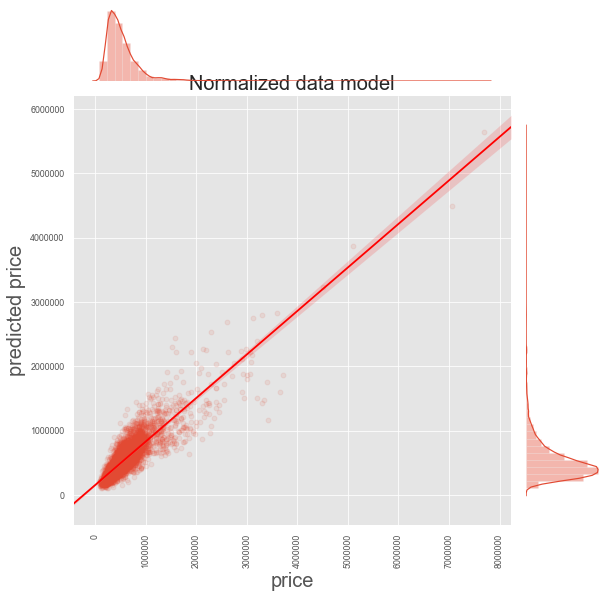

In [40]:
# Boolean variables that control
log_transform_data = True
normalize_data = True
add_onehot_zipcodes = False

num_splits = 10 # We will perform 10 independent test-train splits whenever testing a model
test_size = 0.33 # We will use 2/3 of the data to train and 1/3 of the data to test
log_transform_variables = ['price', 'bedrooms', 'bathrooms', 'sqft_living', # We have chosen these variables
                           'sqft_lot', 'floors', 'condition', 'grade',      # for log transformation
                           'sqft_above', 'sqft_living15', 'sqft_lot15']
perform_checks = False # Can be used to test various assumptions for applying linear regression
apply_feature_selection = False # Can be used to systematically reduce the number of features used to make predictions
n_features_to_select = 10 # The number of features to reach during feature selection
columns_to_standardize = ['bedrooms', 'bathrooms', # These chosen variables will be standardized using Z-score normalization
                                'sqft_living', 'sqft_lot', 'floors', 
                                'condition', 'grade', 'sqft_above',
                                'sqft_living15', 'sqft_lot15']


### Loading data
df = load_kc_data(filename='kc_house_data.csv', verbose=False)

### Checking and cleaning data
df = replace_with_year(df, 'date') # Take only the year information from the date column
                                   # We assume that the month and day are not useful for predicting price
df = drop_columns(df, ["id"])      # Drop the id column, which we assume is not useful for prediction
df = drop_na_rows(df, ["waterfront", "view"]) # Drop the rows that have NA values for waterfront and view
                                              # These columns may be important for predicting price and 
                                              # it is not obvious how to fill these missing values. Furthermore,
                                              # there are relatively few rows with missing values in these columns.
df = convert_columns_with_types(df, "yr_renovated", int, fill_na=True) # Convert yr_renovated to int for compatibility
                                                                       # with the date and yr_built columns
# There are many missing values in yr_renovated, so we fill those missing values with yr_built
df = replace_values_with_another_column(df, [0], "yr_renovated", "yr_built", replace_na=True)
# We will the ? values in sqft_basement with zeros
df = replace_values_with_value(df, '?', 'sqft_basement', '0.0')
# Now that the ? have been changed to zeros, change column type to numeric
df = convert_columns_with_function(df, "sqft_basement", pd.to_numeric)

# Get all of the zipcodes in case one or more zipcodes is missing from a given train-test split of the data
all_zipcodes=df['zipcode'].unique().tolist() 

### Loop over train-test splits and compute and store model quality metrics
train_err = []
test_err = []
train_rsqs = []
test_rsqs = []
train_adj_rsqs = []
test_adj_rsqs = []
for i in range(num_splits):
    ### Split predictors and target for full dataset
    X = df.drop(labels=["price"], axis=1)
    y = df["price"]

    ### Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    ### Build training and test dataframes
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    ### Add onehot zipcodes
    if add_onehot_zipcodes:
        train_df = add_dummy_zipcodes(train_df, all_zipcodes)
        test_df = add_dummy_zipcodes(test_df, all_zipcodes)

    ### Transforming data
    if log_transform_data:
        train_df, train_log_transformed_columns = log_transform_columns(train_df, log_transform_variables,
                                                                  replace_only_when_improved=False, verbose=False, mute=True)
        test_df, test_log_transformed_columns = log_transform_columns(test_df, train_log_transformed_columns,
                                                                  replace_only_when_improved=False, verbose=False, mute=True)

    ### Normalizing data
    if normalize_data:
        normalization_df = train_df.copy()
        train_df = scale_and_normalize_columns(train_df, columns_to_standardize, 
                                               [standardization]*len(columns_to_standardize), fit_df=normalization_df)
        test_df = scale_and_normalize_columns(test_df, columns_to_standardize, 
                                               [standardization]*len(columns_to_standardize), fit_df=normalization_df)

    ### Checking if the data satisfy the assumptions for linear regression
    if perform_checks:
        check_for_linear_correlations(df, target='price')
        check_for_normality(df)
        #check_for_heteroscedasticity ## not yet implemented

    ### Apply feature selection
    if apply_feature_selection:
        rfe_features = recursive_feature_elimination_get_features(df, "price", n_features_to_select=n_features_to_select)
        print(rfe_features)
        df = df.loc[:,rfe_features + ["price"]]

    ### Build the model
    train_linreg = build_linear_model_sklearn(train_df, "price")

    ### Compute errors and correlation coefficients
    if log_transform_data:
        y_hat_train = np.exp(get_predictions_from_linear_model_sklearn(train_df, train_linreg, "price"))
        y_hat_test = np.exp(get_predictions_from_linear_model_sklearn(test_df, train_linreg, "price"))
        train_err.append(np.sqrt(mean_squared_error(np.exp(train_df["price"]), y_hat_train)))
        test_err.append(np.sqrt(mean_squared_error(np.exp(test_df["price"]), y_hat_test)))
    else:
        y_hat_train = get_predictions_from_linear_model_sklearn(train_df, train_linreg, "price")
        y_hat_test = get_predictions_from_linear_model_sklearn(test_df, train_linreg, "price")
        train_err.append(np.sqrt(mean_squared_error(train_df["price"], y_hat_train)))
        test_err.append(np.sqrt(mean_squared_error(test_df["price"], y_hat_test)))

    train_rsq = get_rsq_sklearn(train_df, train_linreg, "price")
    train_rsqs.append(train_rsq)
    train_adj_rsq = get_adjusted_rsq_sklearn(train_df, train_linreg, "price")
    train_adj_rsqs.append(train_adj_rsq)

    test_rsq = get_rsq_sklearn(test_df, train_linreg, "price")
    test_rsqs.append(test_rsq)
    test_adj_rsq = get_adjusted_rsq_sklearn(test_df, train_linreg, "price")
    test_adj_rsqs.append(test_adj_rsq)

# Compute and print mean model quality metrics
mean_train_err = np.mean(train_err)
mean_test_err = np.mean(test_err)
mean_train_rsq = np.mean(train_rsqs)
mean_test_rsq = np.mean(test_rsqs)
mean_train_adj_rsq = np.mean(train_adj_rsqs)
mean_test_adj_rsq = np.mean(test_adj_rsqs)
print(f"Mean train error: {mean_train_err: .0f}\n Mean test error: {mean_test_err: .0f}\n")
print(f"Mean train rsq: {mean_train_rsq: .2f}\n Mean test rsq: {mean_test_rsq: .2f}\n")
print(f"Mean train adj rsq: {mean_train_adj_rsq: .2f}\n Mean test adj rsq: {mean_test_adj_rsq: .2f}\n")

print(f"R-squared: {mean_test_rsq: .2f}, RMSE: {mean_test_err: .0f}")

# Plot the results on the train and test sets of data
plot_predictions_vs_reality(test_df, "price", y_hat_test, 
                            log_transform_target=log_transform_data, title="Normalized data model")

Normalization of the input data did not significantly improve the quality of the predictions

# One-hot encoding of zipcodes
- Housing prices may vary significantly by zipcode, but the raw zipcode data is not expected to be correlated to housing prices
- We used one-hot encoding to add 70 new feature columns to our data set
- The original zipcode column was then dropped from the data set

Mean train error:  131535
 Mean test error:  132882

Mean train rsq:  0.88
 Mean test rsq:  0.88

Mean train adj rsq:  0.88
 Mean test adj rsq:  0.88

R-squared:  0.88, RMSE:  132882


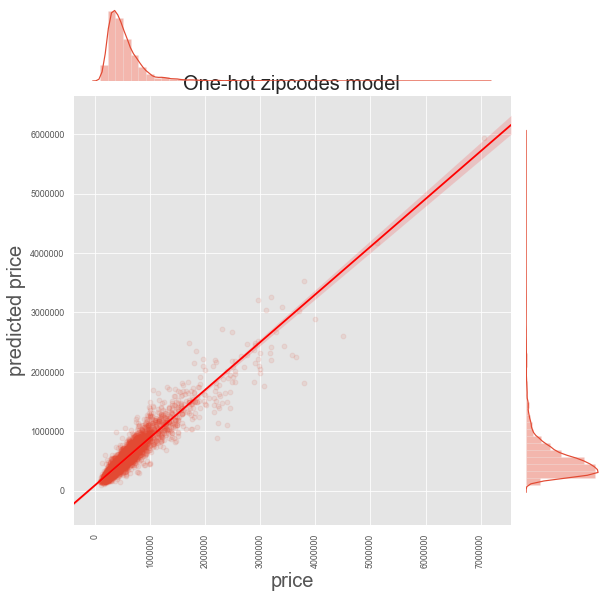

In [41]:
# Boolean variables that control
log_transform_data = True
normalize_data = True
add_onehot_zipcodes = True

num_splits = 10 # We will perform 10 independent test-train splits whenever testing a model
test_size = 0.33 # We will use 2/3 of the data to train and 1/3 of the data to test
log_transform_variables = ['price', 'bedrooms', 'bathrooms', 'sqft_living', # We have chosen these variables
                           'sqft_lot', 'floors', 'condition', 'grade',      # for log transformation
                           'sqft_above', 'sqft_living15', 'sqft_lot15']
perform_checks = False # Can be used to test various assumptions for applying linear regression
apply_feature_selection = False # Can be used to systematically reduce the number of features used to make predictions
n_features_to_select = 10 # The number of features to reach during feature selection
columns_to_standardize = ['bedrooms', 'bathrooms', # These chosen variables will be standardized using Z-score normalization
                                'sqft_living', 'sqft_lot', 'floors', 
                                'condition', 'grade', 'sqft_above',
                                'sqft_living15', 'sqft_lot15']


### Loading data
df = load_kc_data(filename='kc_house_data.csv', verbose=False)

### Checking and cleaning data
df = replace_with_year(df, 'date') # Take only the year information from the date column
                                   # We assume that the month and day are not useful for predicting price
df = drop_columns(df, ["id"])      # Drop the id column, which we assume is not useful for prediction
df = drop_na_rows(df, ["waterfront", "view"]) # Drop the rows that have NA values for waterfront and view
                                              # These columns may be important for predicting price and 
                                              # it is not obvious how to fill these missing values. Furthermore,
                                              # there are relatively few rows with missing values in these columns.
df = convert_columns_with_types(df, "yr_renovated", int, fill_na=True) # Convert yr_renovated to int for compatibility
                                                                       # with the date and yr_built columns
# There are many missing values in yr_renovated, so we fill those missing values with yr_built
df = replace_values_with_another_column(df, [0], "yr_renovated", "yr_built", replace_na=True)
# We will the ? values in sqft_basement with zeros
df = replace_values_with_value(df, '?', 'sqft_basement', '0.0')
# Now that the ? have been changed to zeros, change column type to numeric
df = convert_columns_with_function(df, "sqft_basement", pd.to_numeric)

# Get all of the zipcodes in case one or more zipcodes is missing from a given train-test split of the data
all_zipcodes=df['zipcode'].unique().tolist() 

### Loop over train-test splits and compute and store model quality metrics
train_err = []
test_err = []
train_rsqs = []
test_rsqs = []
train_adj_rsqs = []
test_adj_rsqs = []
for i in range(num_splits):
    ### Split predictors and target for full dataset
    X = df.drop(labels=["price"], axis=1)
    y = df["price"]

    ### Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    ### Build training and test dataframes
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    ### Add onehot zipcodes
    if add_onehot_zipcodes:
        train_df = add_dummy_zipcodes(train_df, all_zipcodes)
        test_df = add_dummy_zipcodes(test_df, all_zipcodes)

    ### Transforming data
    if log_transform_data:
        train_df, train_log_transformed_columns = log_transform_columns(train_df, log_transform_variables,
                                                                  replace_only_when_improved=False, verbose=False, mute=True)
        test_df, test_log_transformed_columns = log_transform_columns(test_df, train_log_transformed_columns,
                                                                  replace_only_when_improved=False, verbose=False, mute=True)

    ### Normalizing data
    if normalize_data:
        normalization_df = train_df.copy()
        train_df = scale_and_normalize_columns(train_df, columns_to_standardize, 
                                               [standardization]*len(columns_to_standardize), fit_df=normalization_df)
        test_df = scale_and_normalize_columns(test_df, columns_to_standardize, 
                                               [standardization]*len(columns_to_standardize), fit_df=normalization_df)

    ### Checking if the data satisfy the assumptions for linear regression
    if perform_checks:
        check_for_linear_correlations(df, target='price')
        check_for_normality(df)
        #check_for_heteroscedasticity ## not yet implemented

    ### Apply feature selection
    if apply_feature_selection:
        rfe_features = recursive_feature_elimination_get_features(df, "price", n_features_to_select=n_features_to_select)
        print(rfe_features)
        df = df.loc[:,rfe_features + ["price"]]

    ### Build the model
    train_linreg = build_linear_model_sklearn(train_df, "price")

    ### Compute errors and correlation coefficients
    if log_transform_data:
        y_hat_train = np.exp(get_predictions_from_linear_model_sklearn(train_df, train_linreg, "price"))
        y_hat_test = np.exp(get_predictions_from_linear_model_sklearn(test_df, train_linreg, "price"))
        train_err.append(np.sqrt(mean_squared_error(np.exp(train_df["price"]), y_hat_train)))
        test_err.append(np.sqrt(mean_squared_error(np.exp(test_df["price"]), y_hat_test)))
    else:
        y_hat_train = get_predictions_from_linear_model_sklearn(train_df, train_linreg, "price")
        y_hat_test = get_predictions_from_linear_model_sklearn(test_df, train_linreg, "price")
        train_err.append(np.sqrt(mean_squared_error(train_df["price"], y_hat_train)))
        test_err.append(np.sqrt(mean_squared_error(test_df["price"], y_hat_test)))

    train_rsq = get_rsq_sklearn(train_df, train_linreg, "price")
    train_rsqs.append(train_rsq)
    train_adj_rsq = get_adjusted_rsq_sklearn(train_df, train_linreg, "price")
    train_adj_rsqs.append(train_adj_rsq)

    test_rsq = get_rsq_sklearn(test_df, train_linreg, "price")
    test_rsqs.append(test_rsq)
    test_adj_rsq = get_adjusted_rsq_sklearn(test_df, train_linreg, "price")
    test_adj_rsqs.append(test_adj_rsq)

# Compute and print mean model quality metrics
mean_train_err = np.mean(train_err)
mean_test_err = np.mean(test_err)
mean_train_rsq = np.mean(train_rsqs)
mean_test_rsq = np.mean(test_rsqs)
mean_train_adj_rsq = np.mean(train_adj_rsqs)
mean_test_adj_rsq = np.mean(test_adj_rsqs)
print(f"Mean train error: {mean_train_err: .0f}\n Mean test error: {mean_test_err: .0f}\n")
print(f"Mean train rsq: {mean_train_rsq: .2f}\n Mean test rsq: {mean_test_rsq: .2f}\n")
print(f"Mean train adj rsq: {mean_train_adj_rsq: .2f}\n Mean test adj rsq: {mean_test_adj_rsq: .2f}\n")

print(f"R-squared: {mean_test_rsq: .2f}, RMSE: {mean_test_err: .0f}")

# Plot the results on the train and test sets of data
plot_predictions_vs_reality(test_df, "price", y_hat_test, 
                            log_transform_target=log_transform_data, title="One-hot zipcodes model")

- Adding additional features using one-hot encoding of the zipcodes significantly improves both the R-squared value and the root-mean-squared error
- The root-mean-squared error of ~$130,000 still seems quite high, despite having an R-squared value of almost 0.9

# Preliminary conclusions
- It looks like log transforming of both the data and target variables can be useful
- Using one-hot encoding of zipcodes improves the predictions significantly
- Although the final R-squared sounds high (~0.9), the corresponding RMSE also seems high
- Further elaboration of the model(s) would be necessary to produce usefully accurate home sale price predictions

# Further considerations
- Deriving new features by non-linear transformations of the given data
 - For example, computing an average price per sqft of living space for each zipcode in the training set
- Other types of data transformations
 - Generalizations of the log transform such as the Box-Cox transforms
- Other types of data normalization
 - Min-max or unit vector normalizations
- Checking for outliers
 - One house in this data set has 33 bedrooms, which is obviously a mistake
 - Could exclude all rows that contain data that are beyond a given number of standard deviations
- Checking the assumptions behind linear regression
 - Linearity
 - Normality: normality tests indicate that the distributions of most variables is clearly not normal but also that one non-normal distribution can be significantly "more normal" than another
 - Homoscedasticity
- Feature selection
 - Recursive feature elimination
 - Stepwise feature selection
- Interpretation of coefficients in regression
 - Which variables apparently contribute the most to predicting price?
- Different models for different zipcodes
 - Could build separate models for each zipcode or each "home type"
- Clustering 
 - Clustering based spatial proximity (using lat and long) or based on home type similarity (number of bathrooms, bedrooms, etc.) could be used to refine the models or to build separate models for each cluster